<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/RAFT/RAFT_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RAFT Starter**

In this notebook we will learn how to use [RAFT](https://arxiv.org/pdf/2003.12039.pdf) or Recurrent All-Pairs Field Transforms for Optical Flow

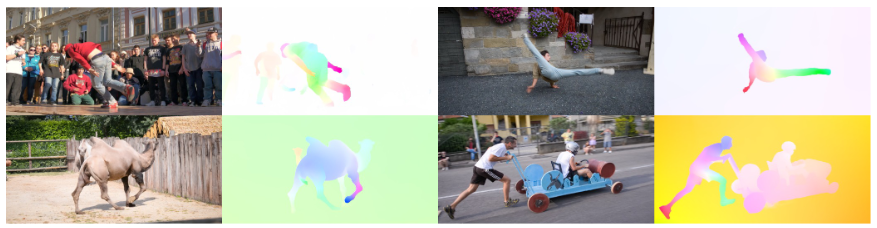

## **RAFT Models**

RAFT has several pretrained models:
 - raft-chairs - trained on FlyingChairs
 - raft-things - trained on FlyingChairs + FlyingThings
 - raft-sintel - trained on FlyingChairs + FlyingThings + Sintel + KITTI
 - raft-kitti - raft-sintel finetuned on only KITTI
 - raft-small - trained on FlyingChairs + FlyingThings

Clone the repo and import libraries

In [1]:
!git clone https://github.com/princeton-vl/RAFT.git

Cloning into 'RAFT'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 147 (delta 0), reused 2 (delta 0), pack-reused 144
Receiving objects: 100% (147/147), 10.01 MiB | 16.23 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [2]:
import os
import sys
import numpy as np
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

Add RAFT core to path

In [3]:
sys.path.append('RAFT/core')

Get demo frames

In [ ]:
# !wget https://github.com/itberrios/CV_projects/blob/main/RAFT/test_images/fan_frame_1.png
# !wget https://github.com/itberrios/CV_projects/blob/main/RAFT/test_images/fan_frame_2.png
# !wget https://github.com/itberrios/CV_projects/blob/main/RAFT/test_images/fan_frame_3.png

In [ ]:
!wget https://raw.githubusercontent.com/itberrios/CV_projects/main/RAFT/test_images/fan_frame_1.png
!wget https://raw.githubusercontent.com/itberrios/CV_projects/main/RAFT/test_images/fan_frame_2.png
!wget https://raw.githubusercontent.com/itberrios/CV_projects/main/RAFT/test_images/fan_frame_3.png

In [80]:
demo_path = 'RAFT/demo-frames'
frame1 = cv2.imread('fan_frame_1.png')
frame2 = cv2.imread('fan_frame_2.png')
frame3 = cv2.imread('fan_frame_3.png')

print(frame1.shape)

H, W, _ = frame1.shape
H2, W2 = H//2, W//2

# # resize
# frame1 = cv2.resize(frame1, (W2, H2))
# frame2 = cv2.resize(frame2, (W2, H2))

# # crop top
# frame1 = frame1[200:, :]
# frame2 = frame2[200:, :]

frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

(320, 568, 3)


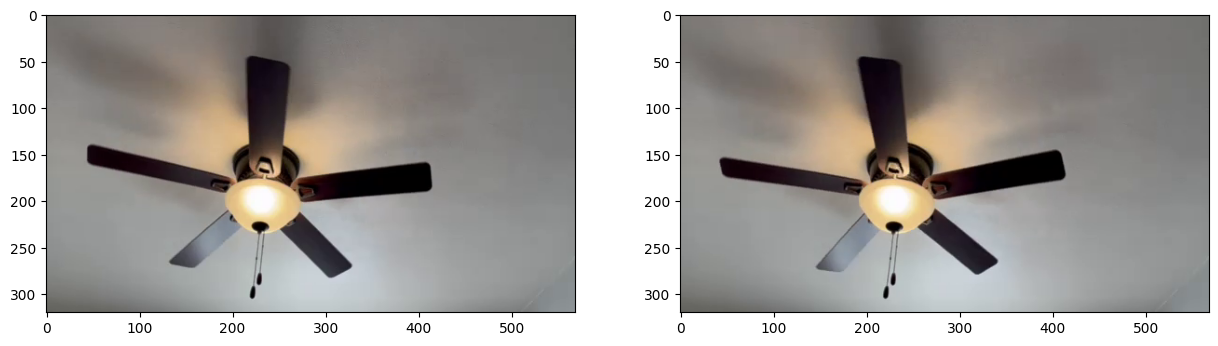

In [81]:
_, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(frame1)
ax[1].imshow(frame2);

## Download models

In [33]:
%cd RAFT
!./download_models.sh
# !python demo.py --model=models/raft-things.pth --path=demo-frames
%cd ..

/content/RAFT
--2023-09-30 14:33:23--  https://dl.dropboxusercontent.com/s/4j4z58wuv8o0mfz/models.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.2.15, 2620:100:6022:15::a27d:420f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.2.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81977417 (78M) [application/zip]
Saving to: ‘models.zip’

models.zip          100%[===================>]  78.18M  78.8MB/s    in 1.0s    

2023-09-30 14:33:25 (78.8 MB/s) - ‘models.zip’ saved [81977417/81977417]

Archive:  models.zip
   creating: models/
  inflating: models/raft-kitti.pth   
  inflating: models/raft-sintel.pth  
  inflating: models/raft-chairs.pth  
  inflating: models/raft-things.pth  
  inflating: models/raft-small.pth   
/content


### Helper functions

In [82]:
from collections import OrderedDict
from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder



def process_img(img, device):
    return torch.from_numpy(img).permute(2, 0, 1).float()[None].to(device)


def load_model(weights_path, args):
    model = RAFT(args)
    pretrained_weights = torch.load(weights_path, map_location=torch.device("cpu"))
    model = torch.nn.DataParallel(model)
    model.load_state_dict(pretrained_weights)
    model.to("cuda")
    return model


def inference(model, frame1, frame2, device, pad_mode='sintel',
              iters=12, flow_init=None, upsample=True, test_mode=True):

    model.eval()
    with torch.no_grad():
        # preprocess
        frame1 = process_img(frame1, device)
        frame2 = process_img(frame2, device)

        padder = InputPadder(frame1.shape, mode=pad_mode)
        frame1, frame2 = padder.pad(frame1, frame2)

        # predict flow
        if test_mode:
          flow_low, flow_up = model(frame1,
                                    frame2,
                                    iters=iters,
                                    flow_init=flow_init,
                                    upsample=upsample,
                                    test_mode=test_mode)



          return flow_low, flow_up

        else:
            flow_iters = model(frame1,
                               frame2,
                               iters=iters,
                               flow_init=flow_init,
                               upsample=upsample,
                               test_mode=test_mode)

            return flow_iters


def get_viz(flo):
    flo = flo[0].permute(1,2,0).cpu().numpy()
    return flow_viz.flow_to_image(flo)

# sketchy class to pass to RAFT
class Args():
  def __init__(self, model='', path='', small=False, mixed_precision=True, alternate_corr=False):
    self.model = model
    self.path = path
    self.small = small
    self.mixed_precision = mixed_precision
    self.alternate_corr = alternate_corr

  """ Sketchy hack to pretend to iterate through the class objects """
  def __iter__(self):
    return self

  def __next__(self):
    raise StopIteration

### Load Model

In [83]:
model = load_model("RAFT/models/raft-sintel.pth", args=Args())

### Predict Optical Flow

In [84]:
flow_low, flow_up = inference(model, frame1, frame2, device='cuda')

In [85]:
flow_low.shape, flow_up.shape

(torch.Size([1, 2, 40, 71]), torch.Size([1, 2, 320, 568]))

### Display Results

In [86]:
flow_low_viz = get_viz(flow_low)
flow_up_viz = get_viz(flow_up)

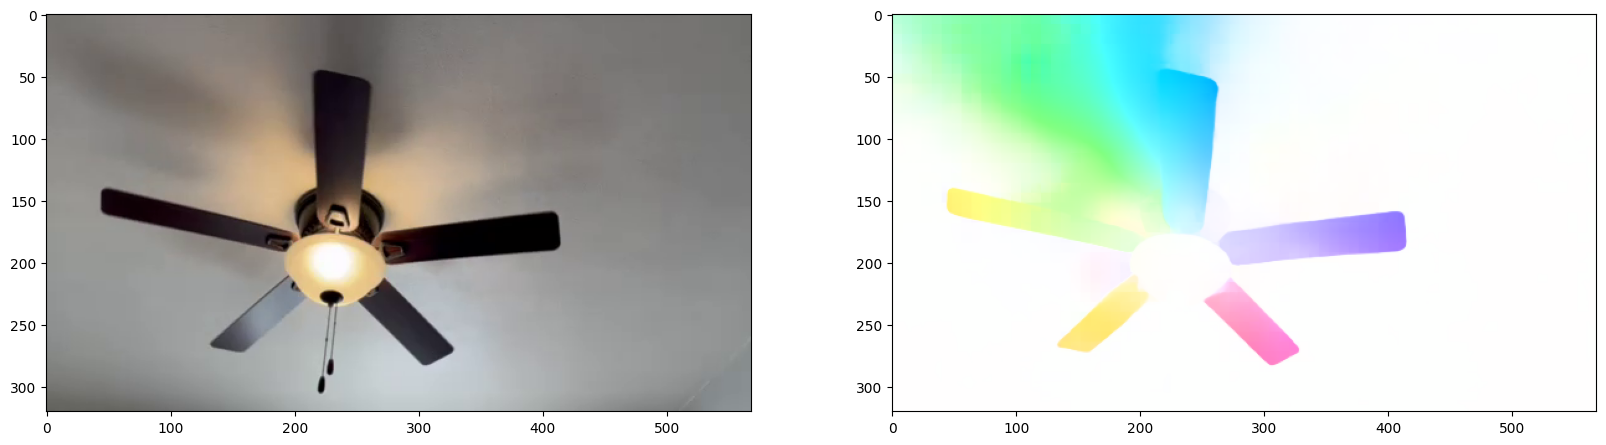

In [87]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(frame1)
ax1.imshow(flow_up_viz)
plt.show()

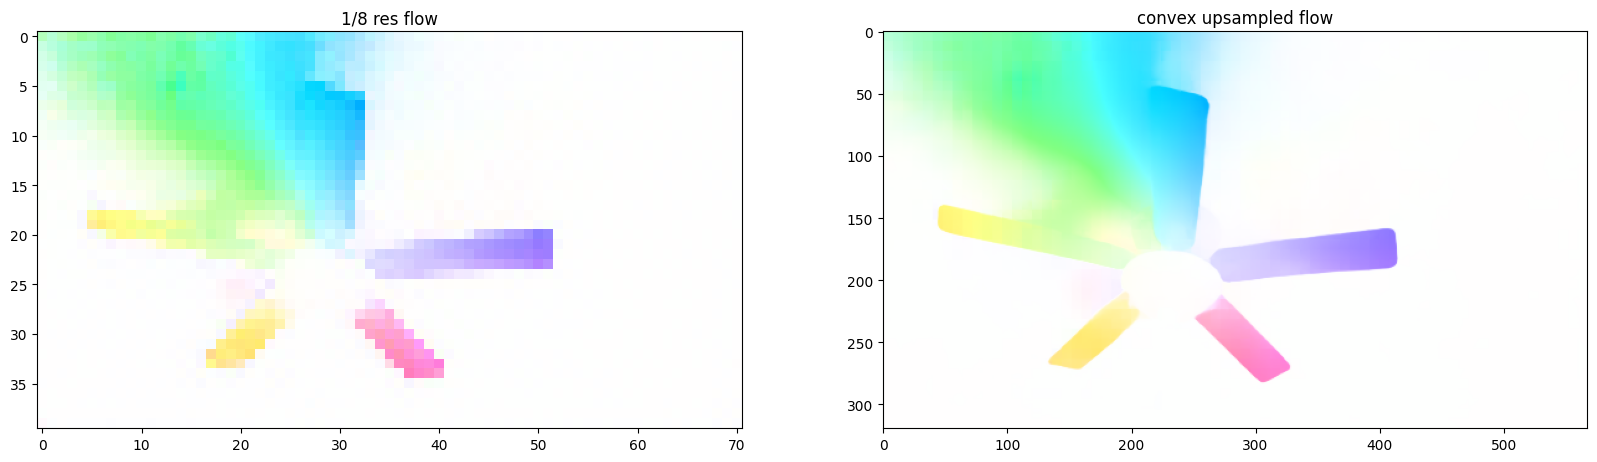

In [88]:
from matplotlib.colors import LogNorm

f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(flow_low_viz)
ax0.set_title('1/8 res flow')
ax1.imshow(flow_up_viz)
ax1.set_title('convex upsampled flow');

In [89]:
flow_iters = inference(model, frame1, frame2, device='cuda', iters=20, test_mode=False)

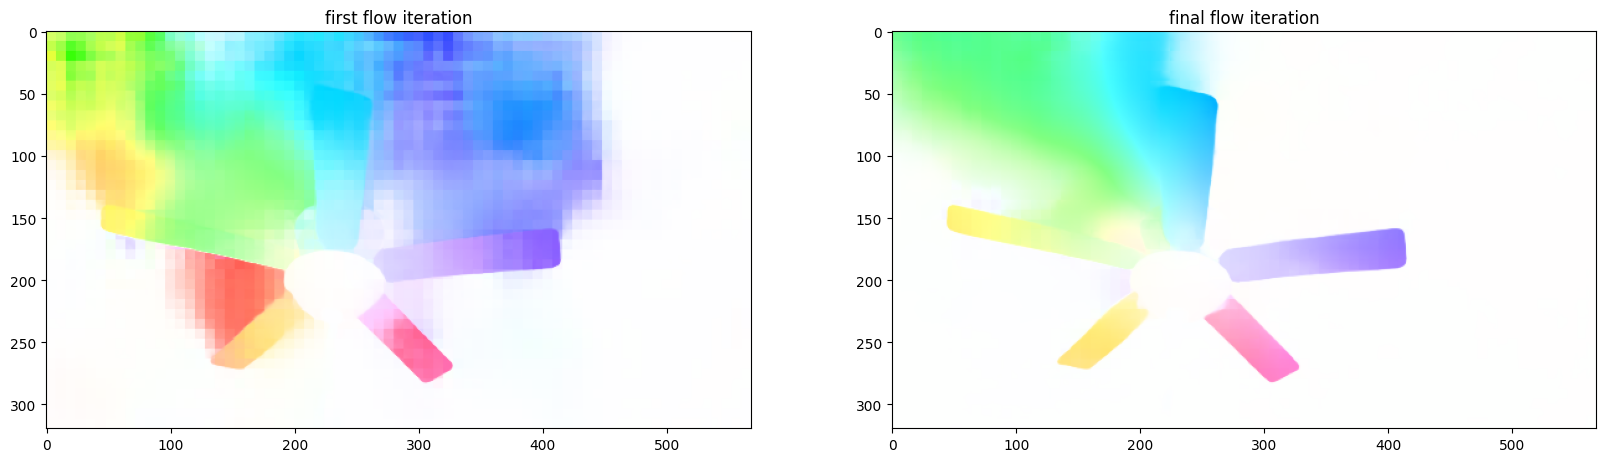

In [90]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(get_viz(flow_iters[0]))
ax0.set_title('first flow iteration')
ax1.imshow(get_viz(flow_iters[-1]))
ax1.set_title('final flow iteration');

## **Estimate Flow with a Warm Start**

In [91]:
flow_lo_cold, flow_up_cold = inference(model, frame2, frame3, device='cuda', iters=20, test_mode=True)
flow_lo_warm, flow_up_warm = inference(model, frame2, frame3, device='cuda', flow_init=flow_lo_cold, iters=20, test_mode=True)

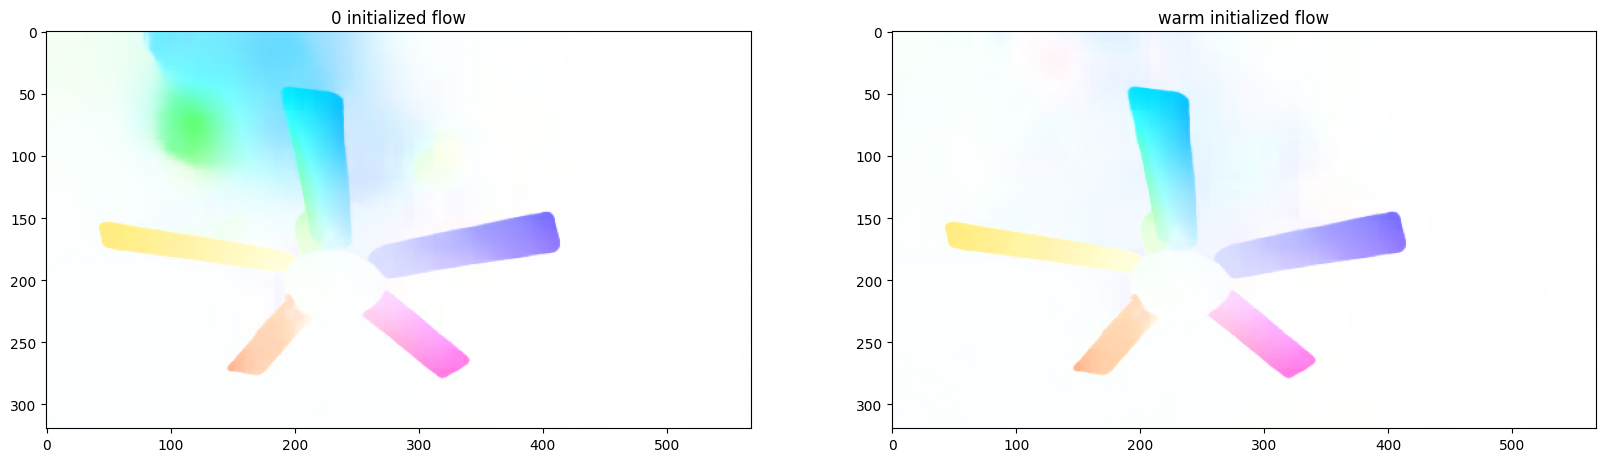

In [93]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(get_viz(flow_up_cold))
ax0.set_title('0 initialized flow')
ax1.imshow(get_viz(flow_up_warm))
ax1.set_title('warm initialized flow');

In [ ]:
1